# 本文件说明
- 统计分析
> - 八分类模型数据：噪音与非噪音
> - 补录和预警数据

# 基本设置

In [1]:
import numpy as np
import pandas as pd
import os
import datetime

import requests,json
from sklearn.externals import joblib

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.setup.date_time import get_day_list
from toolkits.setup import specific_func
specific_func.set_ch_pd()

## 一些函数

In [3]:
def plot_cor(count_data, day_thing, title):
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    rects = count_data[['al_cor', 'al_uncor']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('num', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['al-cor', 'al-uncor'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    count_data[['al_cor_rate', 'al_uncor_rate']].plot(x = count_data['publishtime'],
                                              kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(['al-cor-rate', 'al-uncor-rate'], loc='upper center')

    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in count_data['publishtime'].tolist():
            x = count_data['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(count_data.sort_values(by = 'publishtime', ascending = False).head())

In [4]:
def plot_tend(tend_count, day_thing, title):
    tend_counts = tend_count.set_index(["tendency", 'publishtime']).unstack('tendency')
    tend_counts.columns = ['neg', 'pos']
    tend_counts['sum'] = tend_counts.sum(axis = 1)
    tend_counts['neg_rate'] =  tend_counts['neg'] / tend_counts['sum']
    tend_counts['pos_rate'] =  tend_counts['pos'] / tend_counts['sum']
    tend_counts = tend_counts.reset_index('publishtime')

    tend_counts = tend_counts.sort_values(by = 'publishtime')
    fig = plt.figure(figsize = (15,6))
    ax1 = fig.add_subplot(111)
    tend_counts[['neg', 'pos']].plot(kind = 'bar', ax = ax1, alpha=0.5, stacked=True)
    ax1.set_ylabel('N', fontsize = 16)
    ax1.set_title(title, fontsize = 20)
    ax1.legend(['neg N', 'pos N'], loc='upper left')

    ax2 = ax1.twinx()  # this is the important function
    tend_counts[['neg_rate', 'pos_rate']].plot(x = tend_counts['publishtime'],
                                             kind = 'line', ax = ax2, marker = 'D')
    ax2.set_ylabel('rate', fontsize = 16)
    ax2.set_xlabel('publishtime', fontsize = 16)
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper center')
    y_list = [0.65, 0.75, 0.85, 0.95]
    m = 0
    for [d, t] in day_thing:    
        if d in tend_counts['publishtime'].tolist():
            x = tend_counts['publishtime'].tolist().index(d)
            ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                        color='k', linestyle = "--", alpha = 0.75)
            ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
            if m == 3: 
                m = 0
            else :
                m += 1

    plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
    plt.show()

    print(tend_counts.sort_values(by = 'publishtime', ascending = False).head())

In [5]:
def get_server_res(data, url):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i]['cor']])
    parse_data = pd.DataFrame(parse_data, columns = ['id', 'cor'])    
    return parse_data, elapsed_time

In [6]:
def get_server_res_yjh(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
#     elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data #, elapsed_time

In [7]:
def get_period_data_for_training(human_additional, warning, url, folder, filename, flag):
    combined_data = pd.concat([human_additional, warning])
    print('去重前', combined_data.shape)
    combined_data = combined_data.drop_duplicates(subset = 'id')
    print('去重后', combined_data.shape)

    # predict
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    if flag == 'circ':
        parse_data, elapsed_time = get_server_res(data, url)
    elif flag == 'cbrc':
        col_name = 'sec'
        parse_data = get_server_res_yjh(data, url, col_name)
        
    print(parse_data.shape)
    # parse_data.head()  

    parse_data.columns = ['id', 'predict_label']
    parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
    parse_data['label'] = ''
    # parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
    # parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
    print(parse_data.shape)
    # parse_data.head()

    combined_data = pd.merge(combined_data, parse_data, on  = 'id')
    print(combined_data.head())

    file_path = '%s/result/%s'%(folder, filename)
    combined_data[['id', 'predict_label', 
                   'label', 'title', 'content']].to_excel(file_path, index = False)

In [8]:
def get_class_data(class_count):
    class_count['c'] = class_count['publishtime'] + class_count['classify']
    class_count.index = range(class_count.shape[0])
    combined_count = {}
    for index in class_count.index:
        c = class_count.loc[index, 'c']
        if c not in combined_count:
            combined_count[c] = {}
            combined_count[c]['count'] = class_count.loc[index, 'count']
        else :
            combined_count[c]['count'] = combined_count[c]['count'] + class_count.loc[index, 'count']

        combined_count[c]['publishtime'] = class_count.loc[index, 'publishtime']
        combined_count[c]['classify'] = class_count.loc[index, 'classify']

    class_count = pd.DataFrame().from_dict(combined_count, orient = 'index')
    class_count.index = range(class_count.shape[0])    

    cor_class = class_count.set_index(['publishtime', 'classify']).unstack()#.reset_index('publishtime')
    cor_class['总量'] = cor_class['count'].sum(axis = 1)
    cor_class_1 = cor_class.copy()
    cor_class_1['非噪音'] = cor_class_1['总量'] - cor_class_1['count', '噪音']
    cor_class_1['非噪音-比例'] = cor_class_1['非噪音'] / cor_class_1['总量']
    cor_class_1['噪音-比例'] = cor_class_1['count', '噪音'] / cor_class_1['总量']
    # cor_class_1.sort_index(ascending = False).head()    
    
    for k in cor_class['count'].columns.tolist():
        cor_class['rate', k] = cor_class['count', k] / cor_class['总量']
#     cor_class.sort_index(ascending = False).head()

    count_data_7 = cor_class_1[['总量',  '非噪音', '非噪音-比例', '噪音-比例']]
    count_data_7.insert(2, '噪音', cor_class_1['count', '噪音'])
    count_data_7.columns = ['sum', 'al_cor', 'al_uncor', 'al_cor_rate', 'al_uncor_rate']
    count_data_7 = count_data_7.reset_index()

    cor_list = ['监管', '行业', '公司内部管理', '消费服务']
    count_data_4 = cor_class_1['count'][cor_list].sum(axis = 1).reset_index()
    ss = cor_class_1.reset_index()
    count_data_4 = pd.merge(count_data_4, ss[['总量', 'publishtime']], on = 'publishtime')
    count_data_4.columns = ['publishtime', 'al_cor', 'sum']
    count_data_4['al_uncor'] = count_data_4['sum'] - count_data_4['al_cor']
    count_data_4['al_cor_rate'] = count_data_4['al_cor'] / count_data_4['sum']
    count_data_4['al_uncor_rate'] = count_data_4['al_uncor'] / count_data_4['sum']

    return cor_class_1, cor_class, count_data_7, count_data_4

# 参数设置

In [9]:
today = datetime.datetime.now()
today_str = today.strftime("%Y-%m-%d")
yesterday = today - datetime.timedelta(days=1)
yesterday_str = yesterday.strftime("%Y-%m-%d")
# data_folder = r'D:\XH\OneDrive\网智天元\4 银保监会\cbirc_获取用于人工判断数据\%s'% yesterday_str
# if not os.path.exists(data_folder):
#     os.makedirs(data_folder)

print('今天是：',today.strftime("%Y-%m-%d"))
print('昨天是：',yesterday_str)
print('统计的是昨天的数据，即 %s 的数据'%yesterday_str)
# print('文件存储位置: ', data_folder)

start_day = today - datetime.timedelta(days=31) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = today_str # yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

今天是： 2018-10-22
昨天是： 2018-10-21
统计的是昨天的数据，即 2018-10-21 的数据
start_day： 2018-09-21
end_day： 2018-10-22


In [10]:
label_dic={'补录':0,'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '补录',
 1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [11]:
group = '1-新闻，2-论坛，3-博客，4-微博，5-纸媒，6-视频，7-外媒，8-广播，9-电视，11-微信，13-新闻客户端，15-推特'
group_dict = dict([x.split('-') for x in group.split('，')])
group_dict

{'1': '新闻',
 '11': '微信',
 '13': '新闻客户端',
 '15': '推特',
 '2': '论坛',
 '3': '博客',
 '4': '微博',
 '5': '纸媒',
 '6': '视频',
 '7': '外媒',
 '8': '广播',
 '9': '电视'}

# 保险业--旧

## 特殊时间点

In [12]:
engine = specific_func.get_engine('circ')

In [13]:
circ_day_thing = [['2018-05-31', '上线倾向性模型'], 
             ['2018-06-12', '更新倾向性模型'], 
             ['2018-06-13', '更新倾向性模型'], 
             ['2018-06-15', '更新相关性模型'], 
             ['2018-06-19', '修复bug'], 
             ['2018-06-24', '更新相关性模型'],
             ['2018-06-24', '上线预警模型'], 
             ['2018-06-25', '更新相关性模型（加入交集数据作为噪音）']]

## 八分类

In [14]:
# 相关数据
sql_circ_cor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.classify, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.classify \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_cor_count = pd.read_sql(sql_circ_cor, engine)
circ_cor_count['classify'] = circ_cor_count['classify'].apply(lambda x:class_name_dict[x])
circ_cor_count.head()

,publishtime,classify,count
0,2018-10-22,补录,1
1,2018-10-22,监管,3553
2,2018-10-22,行业,1588
3,2018-10-22,产品销售,863
4,2018-10-22,资本市场,5075


In [15]:
# 不相关数据
sql_circ_uncor = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,t1.classify, count(t1.id) as count \
                            from wise_web_docinfo_uncorr t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by t1.classify, date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

circ_uncor_count = pd.read_sql(sql_circ_uncor, engine)
circ_uncor_count['classify'] = circ_uncor_count['classify'].apply(lambda x:class_name_dict[x])
circ_uncor_count.head()

,publishtime,classify,count
0,2018-10-22,噪音,34200
1,2018-10-21,噪音,45355
2,2018-10-20,噪音,54155
3,2018-10-19,噪音,87702
4,2018-10-18,噪音,97948


### 补录数据

,publishtime,补录
0,2018-10-22,1
8,2018-10-21,1
16,2018-10-20,4
24,2018-10-19,20
32,2018-10-18,20


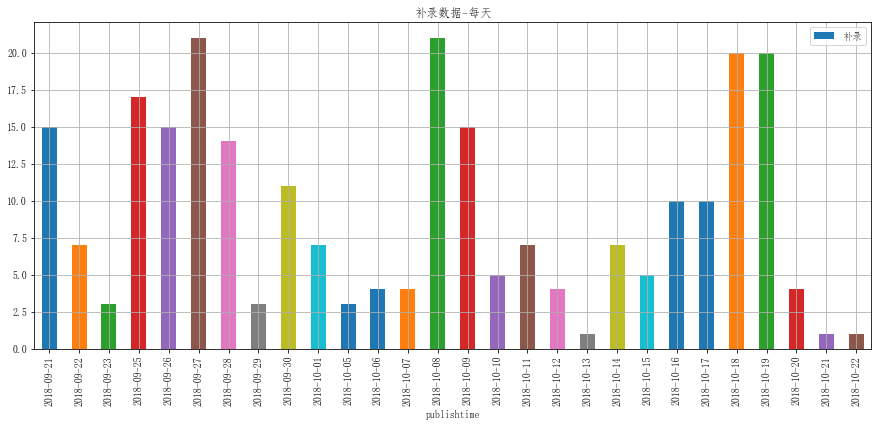

In [16]:
# 补录
apend = circ_cor_count[circ_cor_count['classify'] == '补录'][['publishtime', 'count']]
apend.columns = ['publishtime', '补录']
apend = apend.sort_values(by = 'publishtime', ascending = True)
apend.plot(kind = 'bar', x = 'publishtime', y = '补录', figsize=(15,6), 
           title = '补录数据-每天', grid = True)
apend.sort_values(by = 'publishtime', ascending = False).head()

### class

In [17]:
class_count = pd.concat([circ_cor_count, circ_uncor_count])
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                          \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务        监管       行业   
publishtime                                                                    
2018-10-22   863.000  474.000  815.000 34200.000  541.000  3553.000 1588.000   
2018-10-21   490.000  551.000  616.000 45355.000  831.000  2963.000 1473.000   
2018-10-20   742.000  647.000  747.000 54155.000  589.000  3079.000 1106.000   
2018-10-19  1387.000 2140.000 2109.000 87702.000 1341.000 13976.000 2204.000   
2018-10-18  1878.000 3820.000 2224.000 97948.000 1954.000  2848.000 2976.000   

                                     总量       非噪音 非噪音-比例 噪音-比例  
classify        补录      资本市场                                    
publishtime                                                     
2018-10-22   1.000  5075.000  47110.000 12910.000  0.274 0.726  
2018-10-21   1.000  2578.000  54858.000  9503.000  0.173 0.827  
2018-10-20   4.000  2724.000  63793.000  9638.000  0.151 0.849  
2018-10-19  20.000 20090.000 130969.000 43267.000  0.330 0.670  
2018-10-18  20.000  4551.000 118219.000 20271.000  0.171 0.829

count                                                          \
classify        产品销售   公司内部管理   其他相关报道        噪音     消费服务        监管       行业   
publishtime                                                                    
2018-10-22   863.000  474.000  815.000 34200.000  541.000  3553.000 1588.000   
2018-10-21   490.000  551.000  616.000 45355.000  831.000  2963.000 1473.000   
2018-10-20   742.000  647.000  747.000 54155.000  589.000  3079.000 1106.000   
2018-10-19  1387.000 2140.000 2109.000 87702.000 1341.000 13976.000 2204.000   
2018-10-18  1878.000 3820.000 2224.000 97948.000 1954.000  2848.000 2976.000   

                                     总量  rate                                  \
classify        补录      资本市场             产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管   
publishtime                                                                     
2018-10-22   1.000  5075.000  47110.000 0.018  0.010  0.017 0.726 0.011 0.075   
2018-10-21   1.000  2578.000  54858.000 0.009  0.010  0.011 0.827 0.015 0.054   
2018-10-20   4.000  2724.000  63793.000 0.012  0.010  0.012 0.849 0.009 0.048   
2018-10-19  20.000 20090.000 130969.000 0.011  0.016  0.016 0.670 0.010 0.107   
2018-10-18  20.000  4551.000 118219.000 0.016  0.032  0.019 0.829 0.017 0.024   

                               
classify       行业    补录  资本市场  
publishtime                    
2018-10-22  0.034 0.000 0.108  
2018-10-21  0.027 0.000 0.047  
2018-10-20  0.017 0.000 0.043  
2018-10-19  0.017 0.000 0.153  
2018-10-18  0.025 0.000 0.038

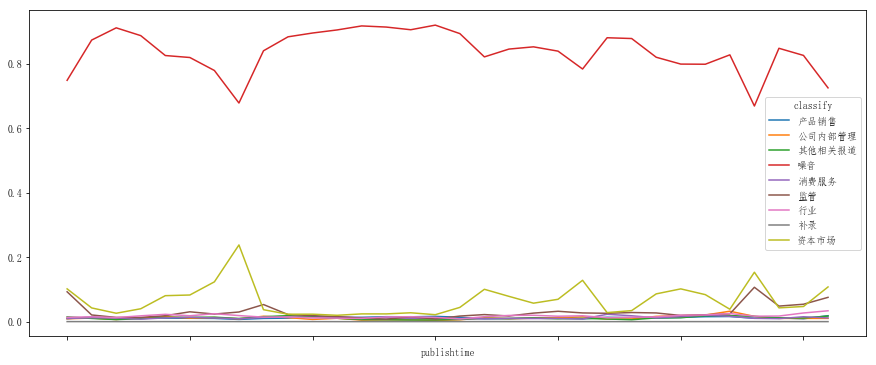

In [18]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

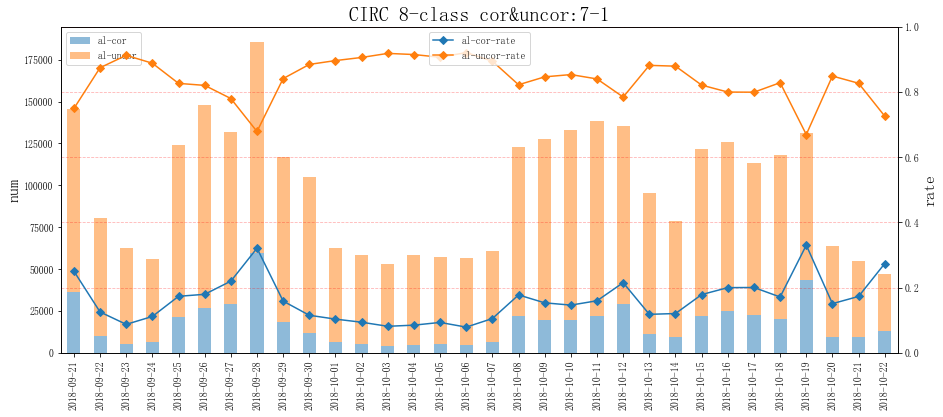

   publishtime        sum    al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-22  47110.000 12910.000 34200.000        0.274          0.726
30  2018-10-21  54858.000  9503.000 45355.000        0.173          0.827
29  2018-10-20  63793.000  9638.000 54155.000        0.151          0.849
28  2018-10-19 130969.000 43267.000 87702.000        0.330          0.670
27  2018-10-18 118219.000 20271.000 97948.000        0.171          0.829


In [19]:
plot_cor(count_data_7, circ_day_thing, "CIRC 8-class cor&uncor:7-1")

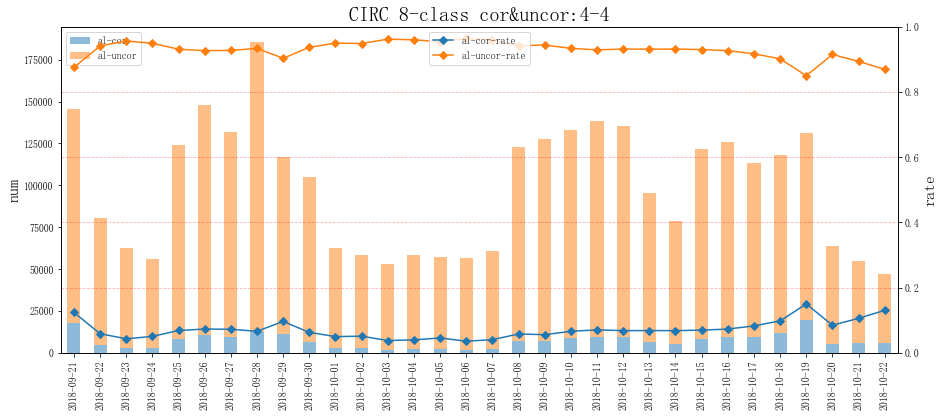

   publishtime    al_cor        sum   al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-22  6156.000  47110.000  40954.000        0.131          0.869
30  2018-10-21  5818.000  54858.000  49040.000        0.106          0.894
29  2018-10-20  5421.000  63793.000  58372.000        0.085          0.915
28  2018-10-19 19661.000 130969.000 111308.000        0.150          0.850
27  2018-10-18 11598.000 118219.000 106621.000        0.098          0.902


In [20]:
plot_cor(count_data_4, circ_day_thing, "CIRC 8-class cor&uncor:4-4")

## 倾向性

In [21]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.tendency, \
                            count(t1.id) as count \
                            from wise_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count.head()

,publishtime,tendency,count
0,2018-10-22,-1,627
1,2018-10-22,0,12284
2,2018-10-21,-1,628
3,2018-10-21,0,8875
4,2018-10-20,-1,834


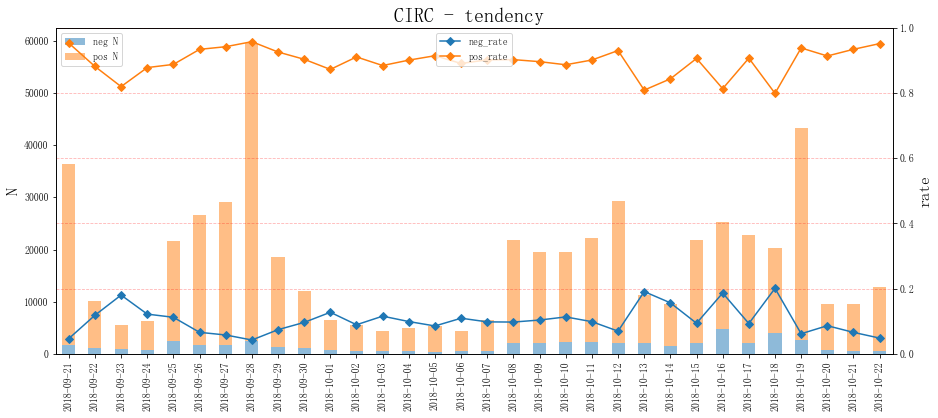

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-10-22   627  12284  12911     0.049     0.951
30  2018-10-21   628   8875   9503     0.066     0.934
29  2018-10-20   834   8804   9638     0.087     0.913
28  2018-10-19  2679  40588  43267     0.062     0.938
27  2018-10-18  4075  16196  20271     0.201     0.799


In [22]:
plot_tend(tend_count, circ_day_thing, "CIRC - tendency ")

### group_id

In [23]:
# sql_tend_group = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
#                             t1.tendency, t1.group_id, count(t1.id) as cor_count \
#                             from wise_web_docinfo t1 \
#                                 where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
#                                       date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
#                                 group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.tendency, t1.group_id \
#                                 order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

# tend_group_count = pd.read_sql(sql_tend_group, engine)
# tend_group_count['group_id'] = tend_group_count['group_id'].apply(lambda x: group_dict[str(x)])
# tend_group_count.head()

## 补录和预警

### 一周数据

In [24]:
add_start_day = '2018-10-13'
add_end_day = '2018-10-19'

In [25]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(73, 7)


In [26]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format(add_start_day, add_end_day) 

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(163, 7)


In [27]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['submited'].replace(0, '不预警').replace(1, '预警')

去重前 (236, 7)
去重后 (166, 7)


In [28]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_i"
url = "http://47.93.77.19:10000/judge_correlation_i"
parse_data, elapsed_time = get_server_res(data, url)
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

,id,predict_label,label,cor,all_cor
0,5614785,行业,,1,1
1,11318838,噪音,,0,0
2,11325122,消费服务,,1,1
3,11331916,噪音,,0,0
4,11331917,资本市场,,0,1


In [29]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [30]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [31]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_cor, on = '来源', how = 'outer')
# stat = pd.merge(stat, stat_a_w_cor, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
# stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
# stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat

来源,微信,微博,新闻,新闻客户端,纸媒,视频,总量
保监会：2018-10-13 到 2018-10-19,,,,,,,
补录,24.000,1.000,42.000,1.000,3.000,2.000,73.000
预警数量,24.000,1.000,103.000,1.000,32.000,2.000,163.000
补录且预警,24.000,1.000,39.000,1.000,3.000,2.000,70.000
补录&过算法(7类),21.000,NaN,33.000,1.000,3.000,1.000,59.000
补录且预警&过算法(7类),21.000,NaN,31.000,1.000,3.000,1.000,57.000
补录且预警 / 预警-比例,100%,100%,38%,100%,9%,100%,43%
补录且预警 / 补录-比例,100%,100%,93%,100%,100%,100%,96%
补录&过算法(7类) / 补录-比例,88%,nan%,79%,100%,100%,50%,81%
补录且预警&过算法(7类) / 补录且预警-比例,88%,nan%,79%,100%,100%,50%,81%


### 导出一段时间补录数据用于训练

In [32]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [33]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.submited, t1.title, t2.center as content\
                            from wise_web_docinfo t1, wise_web_docinfo_center t2 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.submited = 1 ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [34]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_i"
    url = "http://47.93.77.19:10000/judge_correlation_i"
    folder = 'circ_result_class'
    filename = 'circ_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'circ')

# 银行业--旧

## 特殊时间点

In [35]:
engine = specific_func.get_engine('cbrc')

In [36]:
cbrc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

## 八分类

In [37]:
sql_cbrc = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, \
                        t2.traffic_id as classify, count(t1.id) as count \
                            from wise_web_docinfo_basic t1, wise_web_classify_traffic_docinfo t2 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t2.base_id=t1.id \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t2.traffic_id \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

cbrc_count = pd.read_sql(sql_cbrc, engine)
cbrc_count['classify'] = cbrc_count['classify'].apply(lambda x:class_name_dict[x])
cbrc_count.head()

,publishtime,classify,count
0,2018-10-22,监管,11659
1,2018-10-22,行业,5167
2,2018-10-22,产品销售,764
3,2018-10-22,资本市场,10841
4,2018-10-22,公司内部管理,1461


### class

In [38]:
class_count = cbrc_count
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                        总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务     监管     行业   资本市场           
publishtime                                                                   
2018-10-22    764   1461   1753   34592   4372  11659   5167  10841   70609   
2018-10-21    896   1060   1533   44047   5995   8029   4192   7075   72827   
2018-10-20   1574   1414   2391   57210   8687   9151   5613   9051   95091   
2018-10-19   2629   3753   5134   88053  19738  46562  12988  47701  226558   
2018-10-18   3199   5050   6773  100343  17676  15074  19667  31115  198897   

                非噪音 非噪音-比例 噪音-比例  
classify                          
publishtime                       
2018-10-22    36017  0.510 0.490  
2018-10-21    28780  0.395 0.605  
2018-10-20    37881  0.398 0.602  
2018-10-19   138505  0.611 0.389  
2018-10-18    98554  0.496 0.504

count                                                        总量  \
classify     产品销售 公司内部管理 其他相关报道      噪音   消费服务     监管     行业   资本市场           
publishtime                                                                   
2018-10-22    764   1461   1753   34592   4372  11659   5167  10841   70609   
2018-10-21    896   1060   1533   44047   5995   8029   4192   7075   72827   
2018-10-20   1574   1414   2391   57210   8687   9151   5613   9051   95091   
2018-10-19   2629   3753   5134   88053  19738  46562  12988  47701  226558   
2018-10-18   3199   5050   6773  100343  17676  15074  19667  31115  198897   

             rate                                              
classify     产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                                    
2018-10-22  0.011  0.021  0.025 0.490 0.062 0.165 0.073 0.154  
2018-10-21  0.012  0.015  0.021 0.605 0.082 0.110 0.058 0.097  
2018-10-20  0.017  0.015  0.025 0.602 0.091 0.096 0.059 0.095  
2018-10-19  0.012  0.017  0.023 0.389 0.087 0.206 0.057 0.211  
2018-10-18  0.016  0.025  0.034 0.504 0.089 0.076 0.099 0.156

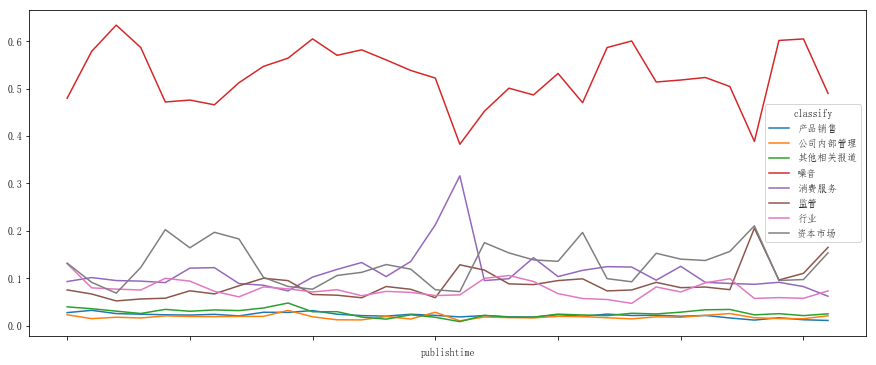

In [39]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

### 总体

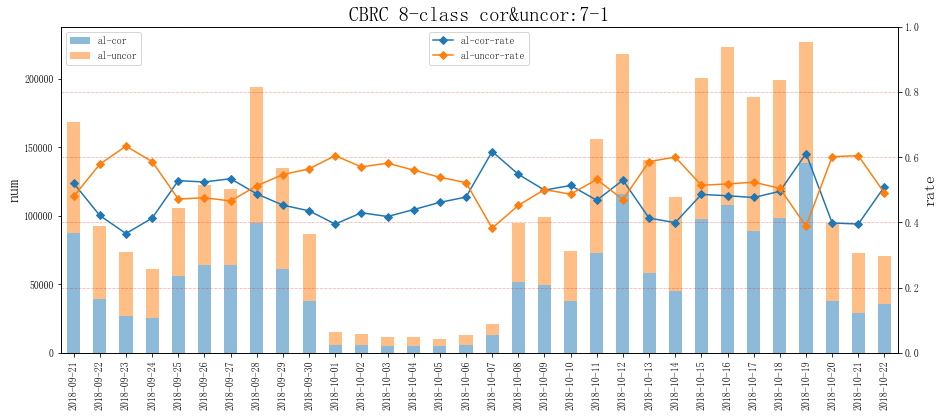

   publishtime     sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-22   70609   36017     34592        0.510          0.490
30  2018-10-21   72827   28780     44047        0.395          0.605
29  2018-10-20   95091   37881     57210        0.398          0.602
28  2018-10-19  226558  138505     88053        0.611          0.389
27  2018-10-18  198897   98554    100343        0.496          0.504


In [40]:
plot_cor(count_data_7, cbrc_day_thing, "CBRC 8-class cor&uncor:7-1")

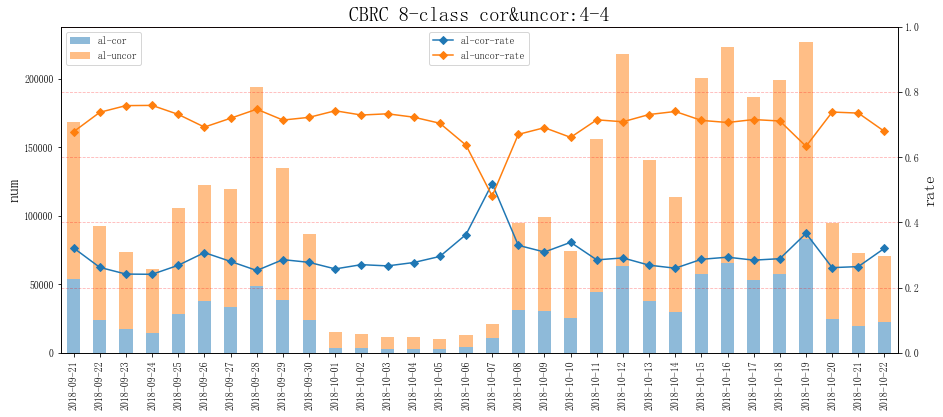

   publishtime  al_cor     sum  al_uncor  al_cor_rate  al_uncor_rate
31  2018-10-22   22659   70609     47950        0.321          0.679
30  2018-10-21   19276   72827     53551        0.265          0.735
29  2018-10-20   24865   95091     70226        0.261          0.739
28  2018-10-19   83041  226558    143517        0.367          0.633
27  2018-10-18   57467  198897    141430        0.289          0.711


In [41]:
plot_cor(count_data_4, cbrc_day_thing, "CBRC 8-class cor&uncor:4-4")

## 倾向性

In [42]:
sql_tend = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime, t1.sen as tendency, count(t1.id) as cor_count \
                            from elint_web_docinfo t1 \
                                where (date_format(t1.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t1.publishtime, '%%Y-%%m-%%d') <= '{1}') \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d'), t1.sen \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
tend_count.head()

,publishtime,tendency,cor_count
0,2018-10-22,-1,695
1,2018-10-22,0,22503
3,2018-10-21,-1,865
4,2018-10-21,0,19067
6,2018-10-20,-1,903


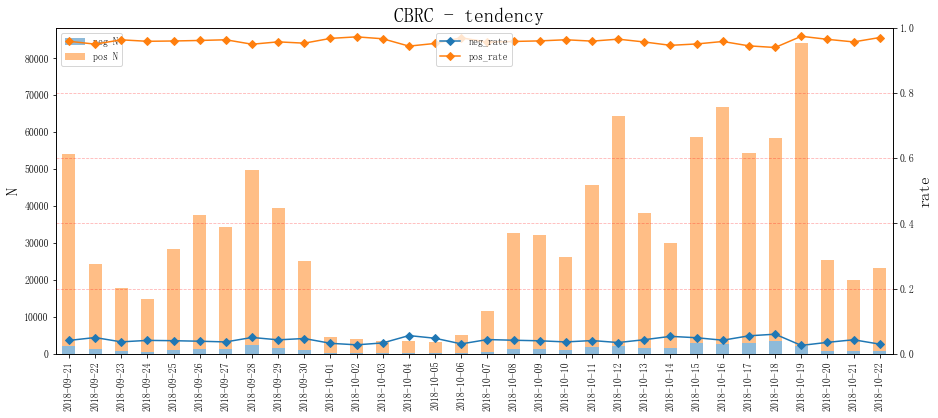

   publishtime   neg    pos    sum  neg_rate  pos_rate
31  2018-10-22   695  22503  23198     0.030     0.970
30  2018-10-21   865  19067  19932     0.043     0.957
29  2018-10-20   903  24554  25457     0.035     0.965
28  2018-10-19  2194  81908  84102     0.026     0.974
27  2018-10-18  3545  55045  58590     0.061     0.939


In [43]:
plot_tend(tend_count, cbrc_day_thing, "CBRC - tendency ")

## 补录和预警

### 补录数据

In [44]:
sql_human_additional = "select date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, count(t1.id) as count \
                            from elint_web_docinfo t1 \
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.gather_type = 1 \
                                group by date_format(t1.publishtime,'%%Y-%%m-%%d') \
                                order by date_format(t1.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

human_additional_count = pd.read_sql(sql_human_additional, engine)
human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

,publishtime,gather_type,count
0,2018-10-22,1,2
1,2018-10-21,1,4
2,2018-10-20,1,10
3,2018-10-19,1,23
4,2018-10-18,1,35


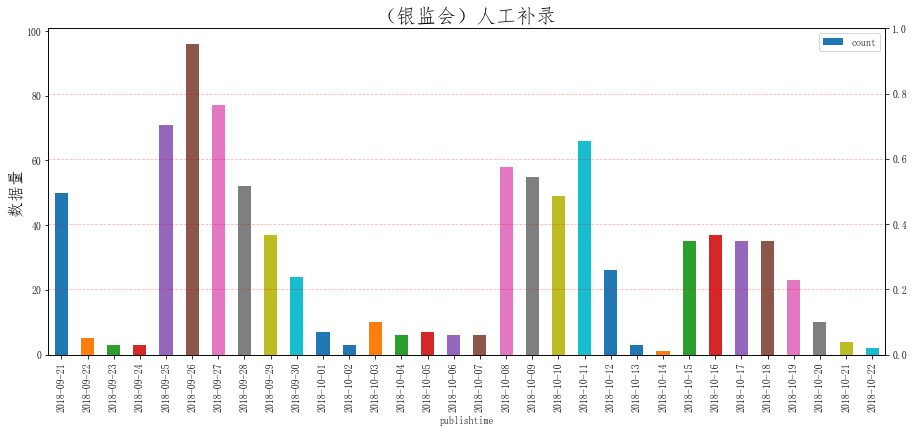

,publishtime,gather_type,count
0,2018-10-22,1,2
1,2018-10-21,1,4
2,2018-10-20,1,10
3,2018-10-19,1,23
4,2018-10-18,1,35


In [45]:
human_additional_count = human_additional_count.sort_values(by = 'publishtime')
fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(111)
human_additional_count.plot(x = 'publishtime', y = 'count', kind = 'bar', figsize = (15, 6), ax = ax1)
ax1.set_ylabel('数据量', fontsize = 16)
ax1.set_title("（银监会）人工补录", fontsize = 20)

ax2 = ax1.twinx()  # this is the important function
ax2.set_ylim(0, 1)
y_list = [0.65, 0.75, 0.85, 0.95]
m = 0
for [d, t] in cbrc_day_thing:    
    if d in human_additional_count['publishtime'].tolist():
        x = human_additional_count['publishtime'].tolist().index(d)
        ax2.axvline(x=x, ymin = y_list[m] - 0.1, ymax = y_list[m] + 0.1, 
                    color='k', linestyle = "--", alpha = 0.75)
        ax2.text(x - 0.25, y_list[m], t, va='center', fontsize = 12)
        if m == 3: 
            m = 0
        else :
            m += 1
        
plt.grid(True, linestyle = "--", color = "r", alpha = 0.3) 
plt.show()

human_additional_count.sort_values(by = 'publishtime', ascending = False).head()

### 一周数据

In [46]:
add_start_day = '2018-10-13'
add_end_day = '2018-10-19'

In [47]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format(add_start_day, add_end_day) 

human_additional = pd.read_sql(sql_human_additional, engine)
print(human_additional.shape)
# human_additional.head()

(169, 7)


In [48]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format(add_start_day, add_end_day)  

warning = pd.read_sql(sql_warning, engine)
print(warning.shape)
# warning.head()

(338, 7)


In [49]:
combined_data = pd.concat([human_additional, warning])
print('去重前', combined_data.shape)
combined_data = combined_data.drop_duplicates(subset = 'id')
print('去重后', combined_data.shape)

combined_data['group_id'] = combined_data['group_id'].apply(lambda x:group_dict[str(x)])
combined_data['gather_type'] = combined_data['gather_type'].replace(0, '系统采集').replace(1, '人工补录').replace(2, '人工修改')
combined_data['submited'] = combined_data['sec'].apply(lambda x: '预警' if x in [7,8,9] else '不预警')
# combined_data.head()

去重前 (507, 7)
去重后 (349, 7)


KeyError: '14'

In [ ]:
combined_data.groupby(['gather_type', 'group_id', 'submited'])['id'].count()

In [ ]:
# predict
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
# url = "http://192.168.0.104:11000/judge_correlation_yjh"
url = "http://47.93.77.19:6001/judge_correlation_yjh"
parse_data = get_server_res_yjh(data, url, 'sec')
# parse_data.head()  

parse_data.columns = ['id', 'predict_label']
parse_data['predict_label'] = parse_data['predict_label'].apply(lambda x:class_name_dict[x])
parse_data['label'] = ''
parse_data['cor'] = parse_data['predict_label'].apply(lambda x:1 if x in ['监管', '行业', '经营管理', '消费服务'] else 0)
parse_data['all_cor'] = parse_data['predict_label'].apply(lambda x:1 if x != '噪音' else 0)
parse_data.head()

In [ ]:
combined_data = pd.merge(combined_data, parse_data, on  = 'id')
stat = combined_data.groupby(['group_id', 'gather_type', 'submited'])['id'].count().reset_index()

# 补录
stat_a = combined_data.groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a = stat_a[stat_a['gather_type'] == '人工补录']

# 补录且预警
stat_a_w = combined_data[combined_data['submited'] == '预警'].groupby(['group_id', 'gather_type'])['id'].count().reset_index()
stat_a_w = stat_a_w[stat_a_w['gather_type'] == '人工补录']

# 预警
stat_w = combined_data.groupby(['group_id', 'submited'])['id'].count().reset_index()
stat_w = stat_w[stat_w['submited'] == '预警']

# 补录-过算法
stat_a_cor = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_cor = stat_a_cor[stat_a_cor['cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'cor'])['id'].count().reset_index()
stat_a_w_cor = stat_a_w_cor[stat_a_w_cor['cor'] == 1]

# 补录-过算法
stat_a_cor_7 = combined_data[combined_data['gather_type'] == '人工补录'].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_cor_7 = stat_a_cor_7[stat_a_cor_7['all_cor'] == 1]

# 补录且预警-过算法
stat_a_w_cor_7 = combined_data[(combined_data['submited'] == '预警') & \
                             (combined_data['gather_type'] == '人工补录')\
                            ].groupby(['group_id', 'all_cor'])['id'].count().reset_index()
stat_a_w_cor_7 = stat_a_w_cor_7[stat_a_w_cor_7['all_cor'] == 1]

In [ ]:
stat_a = stat_a[['group_id', 'id']]
stat_a.columns = ['来源', '补录']
stat_a_w = stat_a_w[['group_id', 'id']]
stat_a_w.columns = ['来源', '补录且预警']
stat_w = stat_w[['group_id', 'id']]
stat_w.columns = ['来源', '预警数量']
stat_a_cor = stat_a_cor[['group_id', 'id']]
stat_a_cor.columns = ['来源', '补录&过算法(4类)']
stat_a_w_cor = stat_a_w_cor[['group_id', 'id']]
stat_a_w_cor.columns = ['来源', '补录且预警&过算法(4类)']
stat_a_cor_7 = stat_a_cor_7[['group_id', 'id']]
stat_a_cor_7.columns = ['来源', '补录&过算法(7类)']
stat_a_w_cor_7 = stat_a_w_cor_7[['group_id', 'id']]
stat_a_w_cor_7.columns = ['来源', '补录且预警&过算法(7类)']

In [ ]:
stat = pd.merge(stat_a, stat_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_cor, on = '来源')
stat = pd.merge(stat, stat_a_w_cor, on = '来源')
stat = pd.merge(stat, stat_a_cor_7, on = '来源', how = 'outer')
stat = pd.merge(stat, stat_a_w_cor_7, on = '来源', how = 'outer')
stat = stat.set_index('来源').stack().unstack(0)
stat = stat.fillna(0)
stat['总量'] =  stat.sum(axis = 1)
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警'] / stat.loc['预警数量'] 
stat.loc['补录且预警 / 预警-比例'] = stat.loc['补录且预警 / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警'] / stat.loc['补录'] 
stat.loc['补录且预警 / 补录-比例'] = stat.loc['补录且预警 / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(4类) / 补录-比例'] = stat.loc['补录&过算法(4类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类)'] / stat.loc['预警数量'] 
stat.loc['补录且预警&过算法(4类) / 预警-比例'] = stat.loc['补录且预警&过算法(4类) / 预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类)'] / stat.loc['补录'] 
stat.loc['补录&过算法(7类) / 补录-比例'] = stat.loc['补录&过算法(7类) / 补录-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类)'] / stat.loc['补录且预警'] 
stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'] = stat.loc['补录且预警&过算法(7类) / 补录且预警-比例'].apply(lambda x: '{:.0f}%'.format(x*100))
stat.index.name = '保监会：{0} 到 {1}'.format(add_start_day, add_end_day)
stat.fillna(0)

### 导出一段时间补录数据用于训练

In [ ]:
# 人工补录
sql_human_additional = "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.gather_type = 1 ".format('2018-08-20', '2018-09-16') 

# human_additional = pd.read_sql(sql_human_additional, engine)
# print(human_additional.shape)
# human_additional.head()

In [ ]:
# 预警数据
sql_warning =  "select t1.id, t1.group_id, date_format(t1.publishtime,'%%Y-%%m-%%d') as publishtime,  \
                            t1.gather_type, t1.sec, t1.title, t2.text as content\
                            from elint_web_docinfo t1, wise_web_docinfo_text t2\
                                where (date_format(publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.id = t2.doc_id and \
                                      t1.sec in (7,8,9) ".format('2018-08-20', '2018-09-16') 

# warning = pd.read_sql(sql_warning, engine)
# print(warning.shape)
# warning.head()

In [ ]:
if 0:
    # url = "http://192.168.0.104:11000/judge_correlation_yjh"
    url = "http://47.93.77.19:6001/judge_correlation_yjh"
    folder = 'cbrc_result_class'
    filename = 'cbrc_add&warning_20180917(0820-0916).xlsx'
    get_period_data_for_training(human_additional, warning, url, folder, filename, 'cbrc')

# 银保监会--新

## 特殊时间点

In [50]:
engine = specific_func.get_engine('cbirc')

In [51]:
cbirc_day_thing = [['2018-05-02', '相关性模型'], 
             ['2018-06-01', '更新相关性模型'], 
             ['2018-06-12', '更新相关性模型'], 
             ['2018-06-12', '上线倾向性模型']
            ]

In [52]:
start_day = today - datetime.timedelta(days=8) # 30 天
start_day = start_day.strftime("%Y-%m-%d") # '2018-08-12'  # 含
end_day = yesterday_str    # 含
print('start_day：',start_day)
print('end_day：',end_day)

start_day： 2018-10-14
end_day： 2018-10-21


## 八分类

In [53]:
sql_cbirc = '''
SELECT 
    DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') AS publishtime,
    t2.type,
    t1.traffic_id AS classify,
    COUNT(t1.id) AS count
FROM
    cbrc_circ.db_classify_traffic_docinfo t1
        LEFT JOIN
    cbrc_circ.db_docinfo_trade t2 ON t1.urlhash = t2.urlhash
        LEFT JOIN
    cbrc_circ.db_docinfo t3 ON t2.urlhash = t3.urlhash
WHERE
    date_format(t3.publishtime, '%%Y-%%m-%%d') >= '{0}'
        AND date_format(t3.publishtime, '%%Y-%%m-%%d') <= '{1}'
GROUP BY DATE_FORMAT(t3.publishtime, '%%Y-%%m-%%d') , t2.type , t1.traffic_id
'''.format(start_day, end_day)

cbirc_count = pd.read_sql(sql_cbirc, engine)
cbirc_count['classify'] = cbirc_count['classify'].apply(lambda x:class_name_dict[x])
print(cbirc_count.shape)
print(cbirc_count.info(memory_usage = 'deep'))
cbirc_count.head()

(256, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 4 columns):
publishtime    256 non-null object
type           256 non-null int64
classify       256 non-null object
count          256 non-null int64
dtypes: int64(2), object(2)
memory usage: 46.3 KB
None


,publishtime,type,classify,count
0,2018-10-14,1,监管,1999
1,2018-10-14,1,行业,1501
2,2018-10-14,1,产品销售,2086
3,2018-10-14,1,资本市场,3001
4,2018-10-14,1,公司内部管理,936


In [54]:
print(cbirc_count['count'].sum())
cbirc_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['count'], 
                        fill_value = 0, margins = True)

1179803


sum                                
              count                                
type              1       2      3       4      All
publishtime                                        
2018-10-14    41760   50137   2086    9983   103966
2018-10-15    84426   79690   4482   23105   191703
2018-10-16    97664   84515   5589   16926   204694
2018-10-17    77205   76019   3453   11894   168571
2018-10-18    77127   72456   4558   15047   169188
2018-10-19    73403   89505   4470   34429   201807
2018-10-20    30164   37666   1460   11344    80634
2018-10-21    20193   29646   1013    8388    59240
All          501942  519634  27111  131116  1179803

In [55]:
# sql_1 = '''
# select 
#     t1.urlhash, t1.type, date_format(t2.publishtime,'%%Y-%%m-%%d') as publishtime
# from 
#     db_docinfo_trade t1, db_docinfo t2
# where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and 
#       date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and
#       t1.urlhash = t2.urlhash'''.format(start_day, end_day) 

# cbirc_count_1 = pd.read_sql(sql_1, engine)
# print(cbirc_count_1.shape)
# print(cbirc_count_1.info(memory_usage = 'deep'))
# cbirc_count_1.head()

In [56]:
# sql_2 = '''
# select 
#     t1.urlhash, t1.traffic_id as classify
# from 
#     db_classify_traffic_docinfo t1, db_docinfo t2
# where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and 
#       date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and
#       t1.urlhash = t2.urlhash'''.format(start_day, end_day) 

# cbirc_count_2 = pd.read_sql(sql_2, engine)
# print(cbirc_count_2.shape)
# print(cbirc_count_2.info(memory_usage = 'deep'))
# cbirc_count_2.head()

In [57]:
# cbirc_merge = pd.merge(cbirc_count_1, cbirc_count_2, on = 'urlhash', how = 'inner')
# print(cbirc_merge.shape)
# cbirc_merge.head()

In [58]:
# cbirc_merge.pivot_table(index = ['publishtime'], columns = ['type'], 
#                         aggfunc = [len], values = ['urlhash'], 
#                         fill_value = 0, margins = True)

In [59]:
# cbirc_count = cbirc_merge.groupby(['type', 'publishtime', 'classify'])['urlhash'].count().reset_index()
# cbirc_count.columns = ['type', 'publishtime', 'classify', 'count']
# cbirc_count.sort_values(by = 'publishtime', ascending = False).head()

### 银监会

In [60]:
class_count = cbirc_count[cbirc_count['type'] == 1].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                   总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场                 
publishtime                                                                     
2018-10-21    570    410    586  14123   700  1264  1116   1424  20193   6070   
2018-10-20   1281    689   1057  21011   761  2086  1456   1823  30164   9153   
2018-10-19   2892   2376   2856  39489  1597  6246  3955  13992  73403  33914   
2018-10-18   3702   3272   4149  47658  1826  3567  6784   6169  77127  29469   
2018-10-17   4433   2706   3910  46772  2526  2823  4392   9643  77205  30433   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-10-21   0.301 0.699  
2018-10-20   0.303 0.697  
2018-10-19   0.462 0.538  
2018-10-18   0.382 0.618  
2018-10-17   0.394 0.606

count                                                   总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场         产品销售   
publishtime                                                                    
2018-10-21    570    410    586  14123   700  1264  1116   1424  20193 0.028   
2018-10-20   1281    689   1057  21011   761  2086  1456   1823  30164 0.042   
2018-10-19   2892   2376   2856  39489  1597  6246  3955  13992  73403 0.039   
2018-10-18   3702   3272   4149  47658  1826  3567  6784   6169  77127 0.048   
2018-10-17   4433   2706   3910  46772  2526  2823  4392   9643  77205 0.057   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-21   0.020  0.029 0.699 0.035 0.063 0.055 0.071  
2018-10-20   0.023  0.035 0.697 0.025 0.069 0.048 0.060  
2018-10-19   0.032  0.039 0.538 0.022 0.085 0.054 0.191  
2018-10-18   0.042  0.054 0.618 0.024 0.046 0.088 0.080  
2018-10-17   0.035  0.051 0.606 0.033 0.037 0.057 0.125

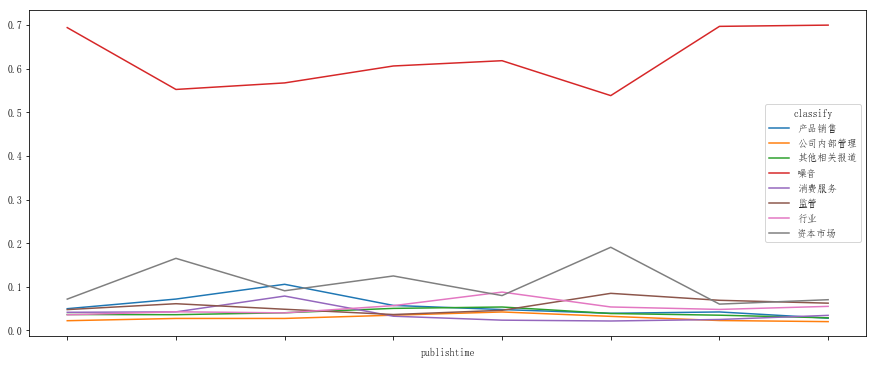

In [61]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

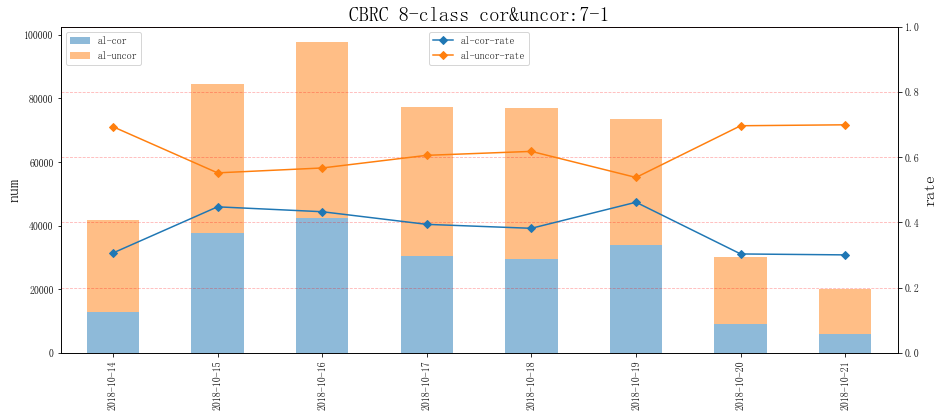

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21  20193    6070     14123        0.301          0.699
6  2018-10-20  30164    9153     21011        0.303          0.697
5  2018-10-19  73403   33914     39489        0.462          0.538
4  2018-10-18  77127   29469     47658        0.382          0.618
3  2018-10-17  77205   30433     46772        0.394          0.606


In [62]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

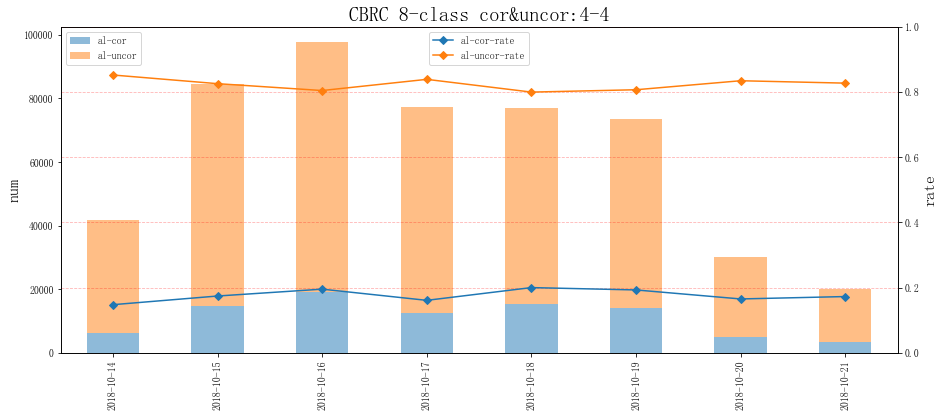

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21    3490  20193     16703        0.173          0.827
6  2018-10-20    4992  30164     25172        0.165          0.835
5  2018-10-19   14174  73403     59229        0.193          0.807
4  2018-10-18   15449  77127     61678        0.200          0.800
3  2018-10-17   12447  77205     64758        0.161          0.839


In [63]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

In [64]:
class_count = cbirc_count[cbirc_count['type'] == 1].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                   总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场                 
publishtime                                                                     
2018-10-21    570    410    586  14123   700  1264  1116   1424  20193   6070   
2018-10-20   1281    689   1057  21011   761  2086  1456   1823  30164   9153   
2018-10-19   2892   2376   2856  39489  1597  6246  3955  13992  73403  33914   
2018-10-18   3702   3272   4149  47658  1826  3567  6784   6169  77127  29469   
2018-10-17   4433   2706   3910  46772  2526  2823  4392   9643  77205  30433   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-10-21   0.301 0.699  
2018-10-20   0.303 0.697  
2018-10-19   0.462 0.538  
2018-10-18   0.382 0.618  
2018-10-17   0.394 0.606

count                                                   总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务    监管    行业   资本市场         产品销售   
publishtime                                                                    
2018-10-21    570    410    586  14123   700  1264  1116   1424  20193 0.028   
2018-10-20   1281    689   1057  21011   761  2086  1456   1823  30164 0.042   
2018-10-19   2892   2376   2856  39489  1597  6246  3955  13992  73403 0.039   
2018-10-18   3702   3272   4149  47658  1826  3567  6784   6169  77127 0.048   
2018-10-17   4433   2706   3910  46772  2526  2823  4392   9643  77205 0.057   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-21   0.020  0.029 0.699 0.035 0.063 0.055 0.071  
2018-10-20   0.023  0.035 0.697 0.025 0.069 0.048 0.060  
2018-10-19   0.032  0.039 0.538 0.022 0.085 0.054 0.191  
2018-10-18   0.042  0.054 0.618 0.024 0.046 0.088 0.080  
2018-10-17   0.035  0.051 0.606 0.033 0.037 0.057 0.125

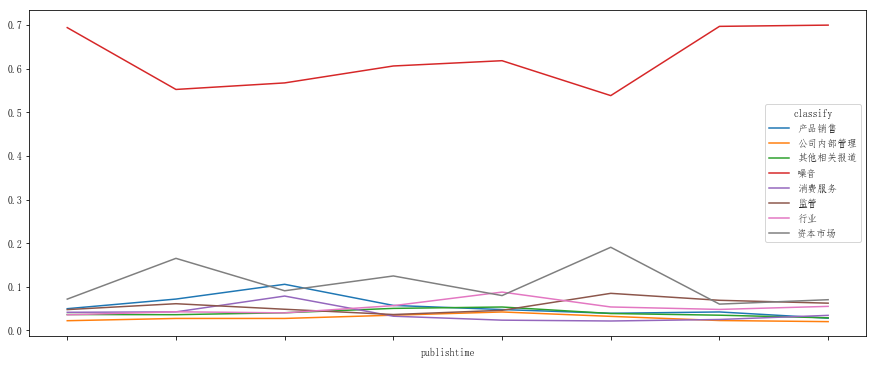

In [65]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

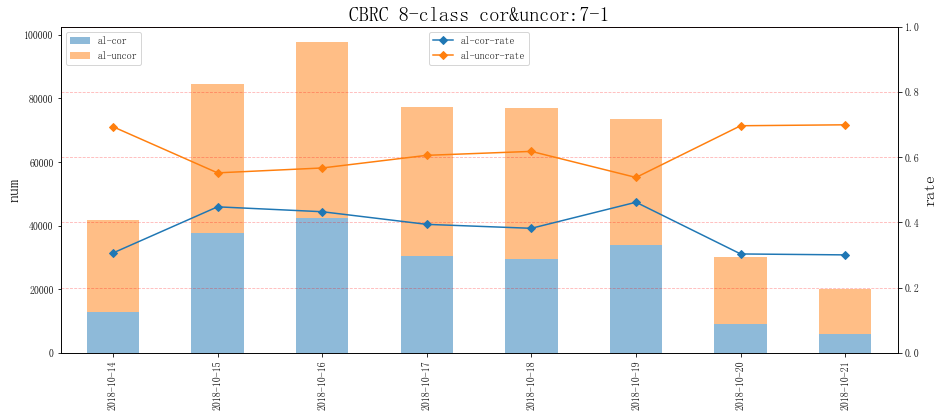

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21  20193    6070     14123        0.301          0.699
6  2018-10-20  30164    9153     21011        0.303          0.697
5  2018-10-19  73403   33914     39489        0.462          0.538
4  2018-10-18  77127   29469     47658        0.382          0.618
3  2018-10-17  77205   30433     46772        0.394          0.606


In [66]:
plot_cor(count_data_7, cbirc_day_thing, "CBRC 8-class cor&uncor:7-1")

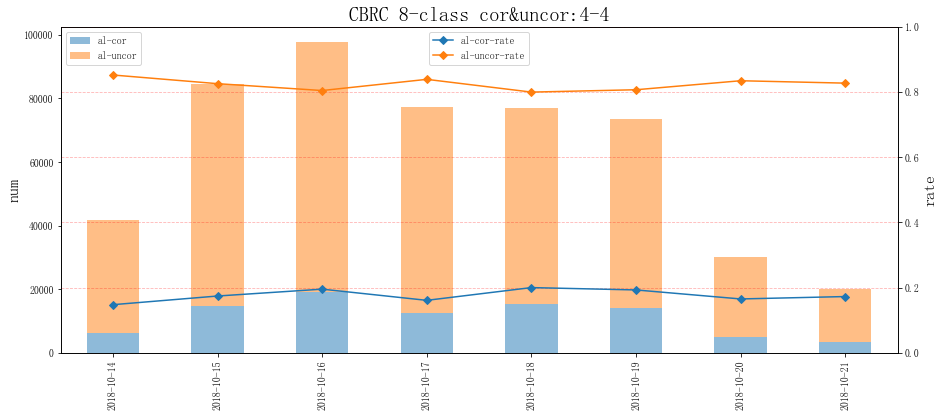

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21    3490  20193     16703        0.173          0.827
6  2018-10-20    4992  30164     25172        0.165          0.835
5  2018-10-19   14174  73403     59229        0.193          0.807
4  2018-10-18   15449  77127     61678        0.200          0.800
3  2018-10-17   12447  77205     64758        0.161          0.839


In [67]:
plot_cor(count_data_4, cbirc_day_thing, "CBRC 8-class cor&uncor:4-4")

### 保监会

In [68]:
class_count = cbirc_count[cbirc_count['type'] == 2].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                    总量  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务     监管    行业   资本市场          
publishtime                                                               
2018-10-21    297    348    211  22234   508   3348  1126   1574  29646   
2018-10-20    384    323    167  29155   456   4421  1166   1594  37666   
2018-10-19    904    839    689  47723  1253  20344  2795  14958  89505   
2018-10-18   1050   1305    744  57700  1585   3758  3633   2681  72456   
2018-10-17    917    561    750  58818  1541   2610  3048   7774  76019   

               非噪音 非噪音-比例 噪音-比例  
classify                         
publishtime                      
2018-10-21    7412  0.250 0.750  
2018-10-20    8511  0.226 0.774  
2018-10-19   41782  0.467 0.533  
2018-10-18   14756  0.204 0.796  
2018-10-17   17201  0.226 0.774

count                                                    总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音  消费服务     监管    行业   资本市场         产品销售   
publishtime                                                                     
2018-10-21    297    348    211  22234   508   3348  1126   1574  29646 0.010   
2018-10-20    384    323    167  29155   456   4421  1166   1594  37666 0.010   
2018-10-19    904    839    689  47723  1253  20344  2795  14958  89505 0.010   
2018-10-18   1050   1305    744  57700  1585   3758  3633   2681  72456 0.014   
2018-10-17    917    561    750  58818  1541   2610  3048   7774  76019 0.012   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-21   0.012  0.007 0.750 0.017 0.113 0.038 0.053  
2018-10-20   0.009  0.004 0.774 0.012 0.117 0.031 0.042  
2018-10-19   0.009  0.008 0.533 0.014 0.227 0.031 0.167  
2018-10-18   0.018  0.010 0.796 0.022 0.052 0.050 0.037  
2018-10-17   0.007  0.010 0.774 0.020 0.034 0.040 0.102

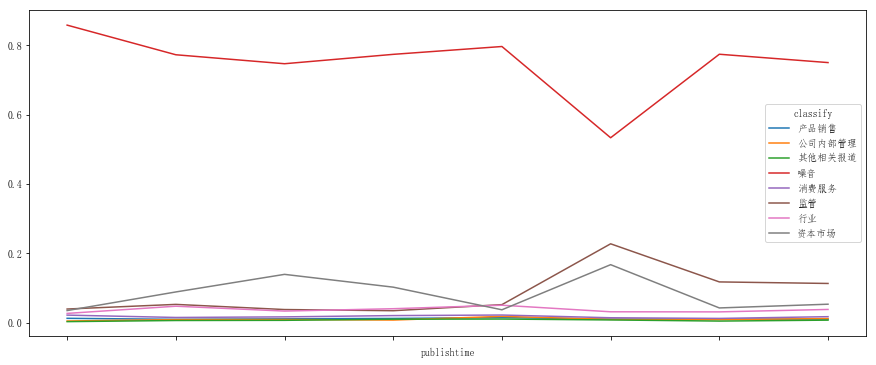

In [69]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

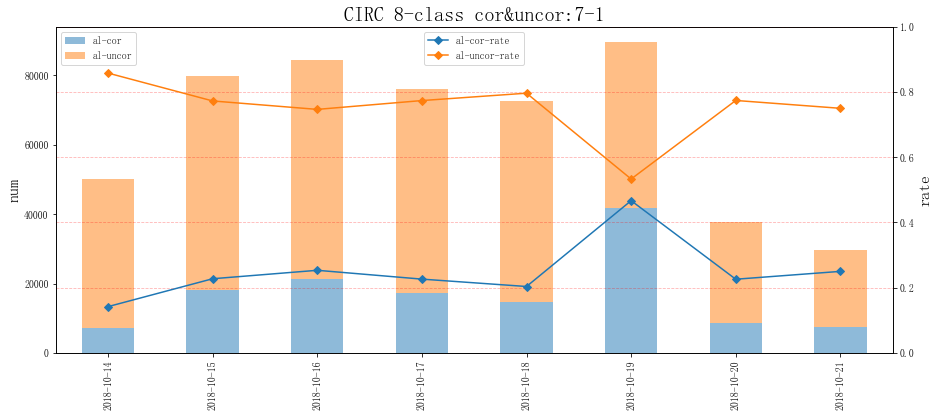

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21  29646    7412     22234        0.250          0.750
6  2018-10-20  37666    8511     29155        0.226          0.774
5  2018-10-19  89505   41782     47723        0.467          0.533
4  2018-10-18  72456   14756     57700        0.204          0.796
3  2018-10-17  76019   17201     58818        0.226          0.774


In [70]:
plot_cor(count_data_7, cbirc_day_thing, "CIRC 8-class cor&uncor:7-1")

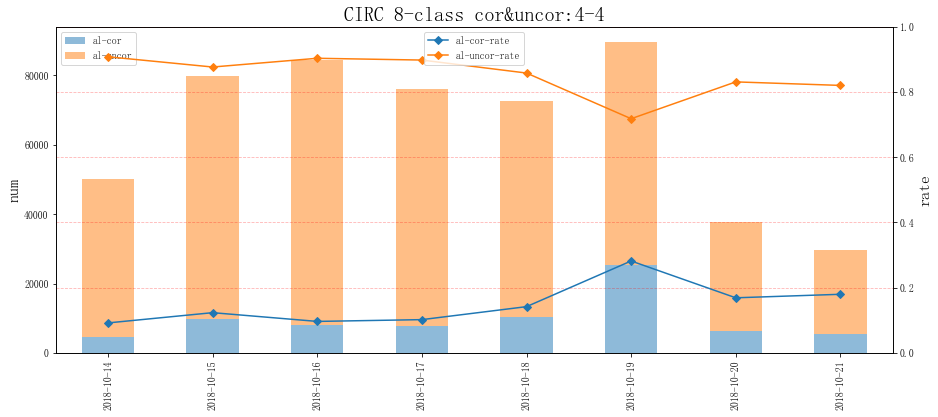

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21    5330  29646     24316        0.180          0.820
6  2018-10-20    6366  37666     31300        0.169          0.831
5  2018-10-19   25231  89505     64274        0.282          0.718
4  2018-10-18   10281  72456     62175        0.142          0.858
3  2018-10-17    7760  76019     68259        0.102          0.898


In [71]:
plot_cor(count_data_4, cbirc_day_thing, "CIRC 8-class cor&uncor:4-4")

### 中国人寿

In [72]:
class_count = cbirc_count[cbirc_count['type'] == 3].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                            总量   非噪音 非噪音-比例  \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场                      
publishtime                                                                    
2018-10-21     21     31     10   597   22   90  165   77  1013   416  0.411   
2018-10-20     18     28     17   982   31  133  186   65  1460   478  0.327   
2018-10-19     54     69     43  2596  139  406  511  652  4470  1874  0.419   
2018-10-18     72    108     48  3185   90  124  448  483  4558  1373  0.301   
2018-10-17     70     94     32  2602   48  134  277  196  3453   851  0.246   

            噪音-比例  
classify           
publishtime        
2018-10-21  0.589  
2018-10-20  0.673  
2018-10-19  0.581  
2018-10-18  0.699  
2018-10-17  0.754

count                                            总量  rate         \
classify     产品销售 公司内部管理 其他相关报道    噪音 消费服务   监管   行业 资本市场        产品销售 公司内部管理   
publishtime                                                                    
2018-10-21     21     31     10   597   22   90  165   77  1013 0.021  0.031   
2018-10-20     18     28     17   982   31  133  186   65  1460 0.012  0.019   
2018-10-19     54     69     43  2596  139  406  511  652  4470 0.012  0.015   
2018-10-18     72    108     48  3185   90  124  448  483  4558 0.016  0.024   
2018-10-17     70     94     32  2602   48  134  277  196  3453 0.020  0.027   

                                                  
classify    其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                       
2018-10-21   0.010 0.589 0.022 0.089 0.163 0.076  
2018-10-20   0.012 0.673 0.021 0.091 0.127 0.045  
2018-10-19   0.010 0.581 0.031 0.091 0.114 0.146  
2018-10-18   0.011 0.699 0.020 0.027 0.098 0.106  
2018-10-17   0.009 0.754 0.014 0.039 0.080 0.057

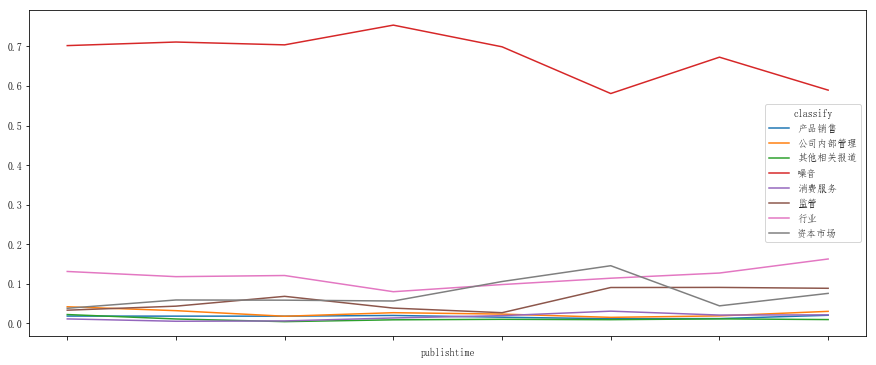

In [73]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

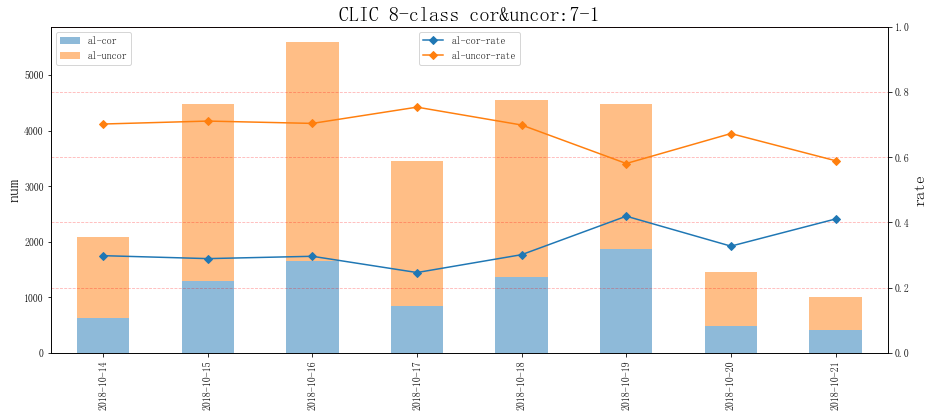

  publishtime   sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21  1013     416       597        0.411          0.589
6  2018-10-20  1460     478       982        0.327          0.673
5  2018-10-19  4470    1874      2596        0.419          0.581
4  2018-10-18  4558    1373      3185        0.301          0.699
3  2018-10-17  3453     851      2602        0.246          0.754


In [74]:
plot_cor(count_data_7, cbirc_day_thing, "CLIC 8-class cor&uncor:7-1")

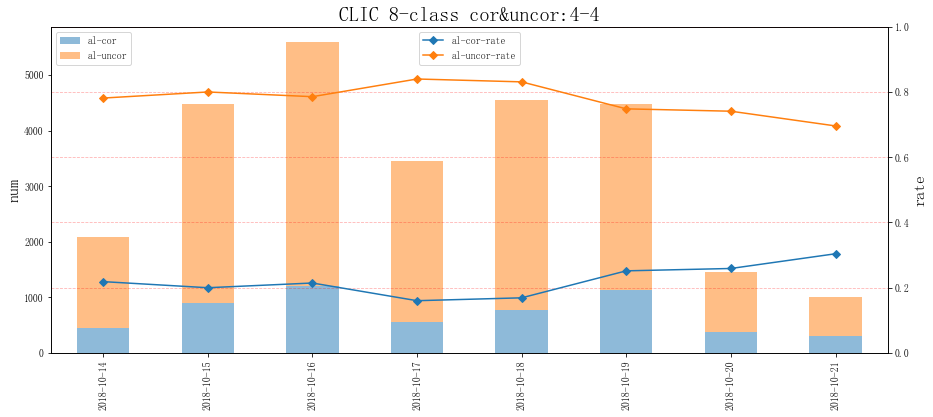

  publishtime  al_cor   sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21     308  1013       705        0.304          0.696
6  2018-10-20     378  1460      1082        0.259          0.741
5  2018-10-19    1125  4470      3345        0.252          0.748
4  2018-10-18     770  4558      3788        0.169          0.831
3  2018-10-17     553  3453      2900        0.160          0.840


In [75]:
plot_cor(count_data_4, cbirc_day_thing, "CLIC 8-class cor&uncor:4-4")

### 建行北分

In [76]:
class_count = cbirc_count[cbirc_count['type'] == 4].drop('type', axis = 1)
cor_class_1, cor_class, count_data_7, count_data_4 = get_class_data(class_count)
cor_class_1.sort_index(ascending = False).head()

count                                                 总量    非噪音  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务     监管   行业  资本市场                 
publishtime                                                                   
2018-10-21    169     84     78   3751  107   2924  376   899   8388   4637   
2018-10-20    293    108     92   5493  146   3888  408   916  11344   5851   
2018-10-19    921    385    404  10898  362  17959  920  2580  34429  23531   
2018-10-18    415    541    573   9855  293   1311  832  1227  15047   5192   
2018-10-17    461    716    552   7290  318   1106  465   986  11894   4604   

            非噪音-比例 噪音-比例  
classify                  
publishtime               
2018-10-21   0.553 0.447  
2018-10-20   0.516 0.484  
2018-10-19   0.683 0.317  
2018-10-18   0.345 0.655  
2018-10-17   0.387 0.613

count                                                 总量  rate  \
classify     产品销售 公司内部管理 其他相关报道     噪音 消费服务     监管   行业  资本市场         产品销售   
publishtime                                                                  
2018-10-21    169     84     78   3751  107   2924  376   899   8388 0.020   
2018-10-20    293    108     92   5493  146   3888  408   916  11344 0.026   
2018-10-19    921    385    404  10898  362  17959  920  2580  34429 0.027   
2018-10-18    415    541    573   9855  293   1311  832  1227  15047 0.028   
2018-10-17    461    716    552   7290  318   1106  465   986  11894 0.039   

                                                         
classify    公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场  
publishtime                                              
2018-10-21   0.010  0.009 0.447 0.013 0.349 0.045 0.107  
2018-10-20   0.010  0.008 0.484 0.013 0.343 0.036 0.081  
2018-10-19   0.011  0.012 0.317 0.011 0.522 0.027 0.075  
2018-10-18   0.036  0.038 0.655 0.019 0.087 0.055 0.082  
2018-10-17   0.060  0.046 0.613 0.027 0.093 0.039 0.083

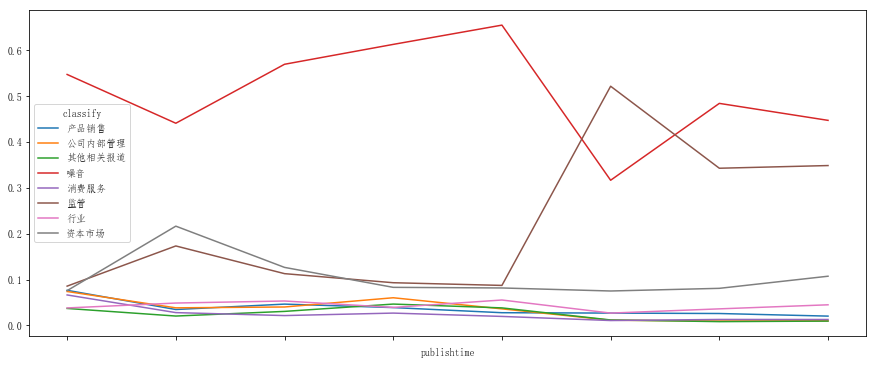

In [77]:
cor_class['rate'].reset_index().fillna(0).plot(x = 'publishtime', figsize = (15,6))
cor_class.sort_index(ascending = False).head()

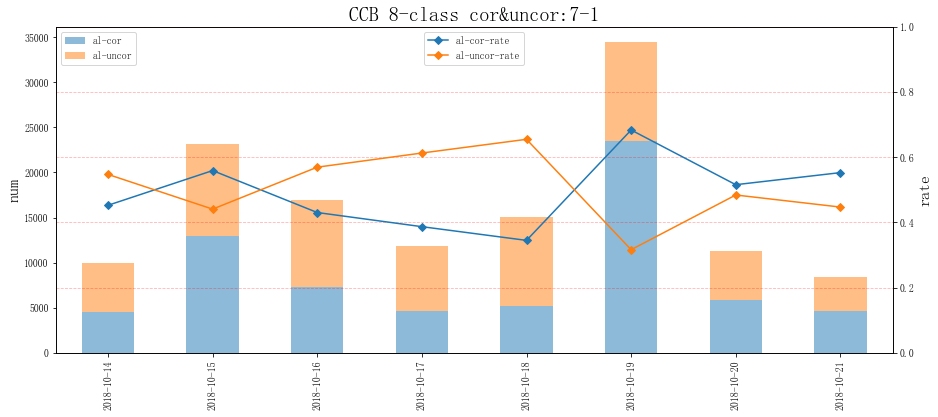

  publishtime    sum  al_cor  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21   8388    4637      3751        0.553          0.447
6  2018-10-20  11344    5851      5493        0.516          0.484
5  2018-10-19  34429   23531     10898        0.683          0.317
4  2018-10-18  15047    5192      9855        0.345          0.655
3  2018-10-17  11894    4604      7290        0.387          0.613


In [78]:
plot_cor(count_data_7, cbirc_day_thing, "CCB 8-class cor&uncor:7-1")

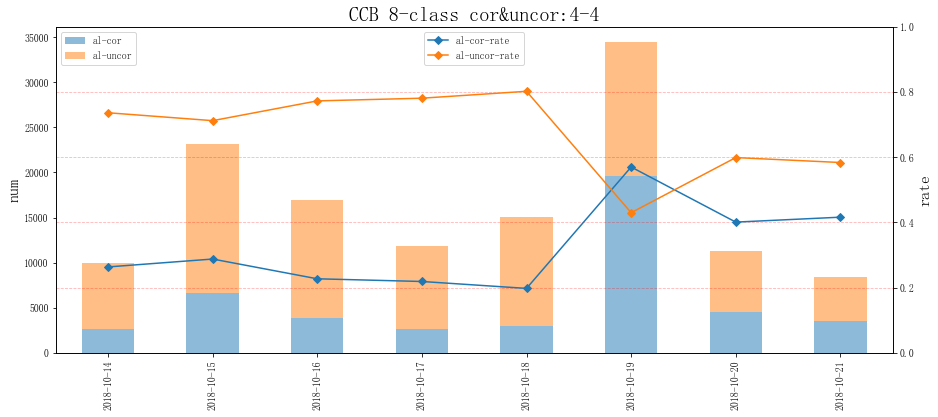

  publishtime  al_cor    sum  al_uncor  al_cor_rate  al_uncor_rate
7  2018-10-21    3491   8388      4897        0.416          0.584
6  2018-10-20    4550  11344      6794        0.401          0.599
5  2018-10-19   19626  34429     14803        0.570          0.430
4  2018-10-18    2977  15047     12070        0.198          0.802
3  2018-10-17    2605  11894      9289        0.219          0.781


In [79]:
plot_cor(count_data_4, cbirc_day_thing, "CCB 8-class cor&uncor:4-4")

## 倾向性

In [80]:
sql_tend = "select date_format(t2.publishtime,'%%Y-%%m-%%d') as publishtime, t1.type, \
                    t1.sen as tendency, count(t1.id) as cor_count \
                            from db_docinfo_trade t1, db_docinfo t2 \
                                where (date_format(t2.publishtime, '%%Y-%%m-%%d') >= '{0}' and \
                                      date_format(t2.publishtime, '%%Y-%%m-%%d') <= '{1}') and \
                                      t1.urlhash = t2.urlhash \
                                group by date_format(t2.publishtime,'%%Y-%%m-%%d'), t1.type, t1.sen \
                                order by date_format(t2.publishtime,'%%Y-%%m-%%d') desc".format(start_day, end_day) 

tend_count = pd.read_sql(sql_tend, engine)
tend_count = tend_count[tend_count['tendency'] != 1]
print(tend_count.shape)
print(tend_count.info(memory_usage = 'deep'))
tend_count.head()

(64, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 4 columns):
publishtime    64 non-null object
type           64 non-null int64
tendency       64 non-null int64
cor_count      64 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.2 KB
None


,publishtime,type,tendency,cor_count
0,2018-10-21,1,-1,391
1,2018-10-21,1,0,23586
2,2018-10-21,2,-1,35
3,2018-10-21,2,0,33452
4,2018-10-21,3,-1,2


In [81]:
print(tend_count['cor_count'].sum())
tend_count.pivot_table(index = ['publishtime'], columns = ['type'], 
                        aggfunc = [np.sum], values = ['cor_count'], 
                        fill_value = 0, margins = True)

1217196


sum                                
            cor_count                                
type                1       2      3       4      All
publishtime                                          
2018-10-14      42307   51769   3774    9219   107069
2018-10-15      85427   82964   6632   21286   196309
2018-10-16      99460   86437   7596   15471   208964
2018-10-17      79945   78988   6142   10807   175882
2018-10-18      80122   75179   6879   13857   176037
2018-10-19      79859   87932   6401   25749   199941
2018-10-20      33423   42113   2797    8731    87064
2018-10-21      23977   33487   2102    6364    65930
All            524520  538869  42323  111484  1217196

### 银监会

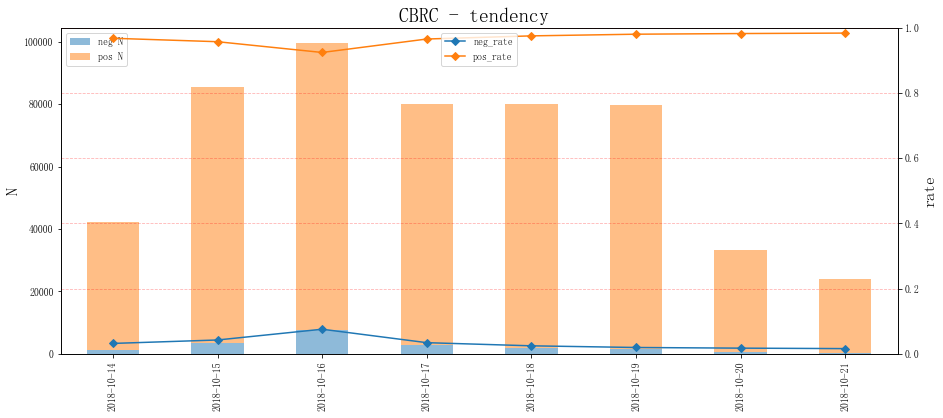

  publishtime   neg    pos    sum  neg_rate  pos_rate
7  2018-10-21   391  23586  23977     0.016     0.984
6  2018-10-20   592  32831  33423     0.018     0.982
5  2018-10-19  1576  78283  79859     0.020     0.980
4  2018-10-18  1991  78131  80122     0.025     0.975
3  2018-10-17  2758  77187  79945     0.034     0.966


In [82]:
plot_tend(tend_count[tend_count['type'] == 1].drop('type', axis = 1), cbirc_day_thing, "CBRC - tendency ")

### 保监会

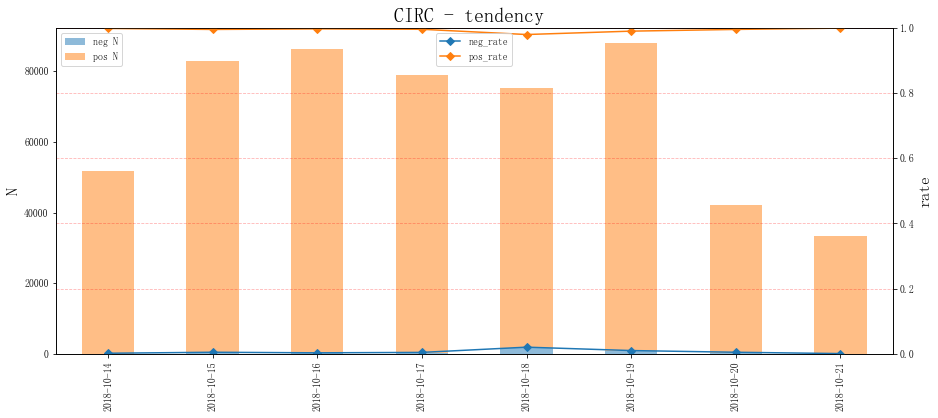

  publishtime   neg    pos    sum  neg_rate  pos_rate
7  2018-10-21    35  33452  33487     0.001     0.999
6  2018-10-20   215  41898  42113     0.005     0.995
5  2018-10-19   910  87022  87932     0.010     0.990
4  2018-10-18  1557  73622  75179     0.021     0.979
3  2018-10-17   367  78621  78988     0.005     0.995


In [83]:
plot_tend(tend_count[tend_count['type'] == 2].drop('type', axis = 1), cbirc_day_thing, "CIRC - tendency ")

### 中国人寿

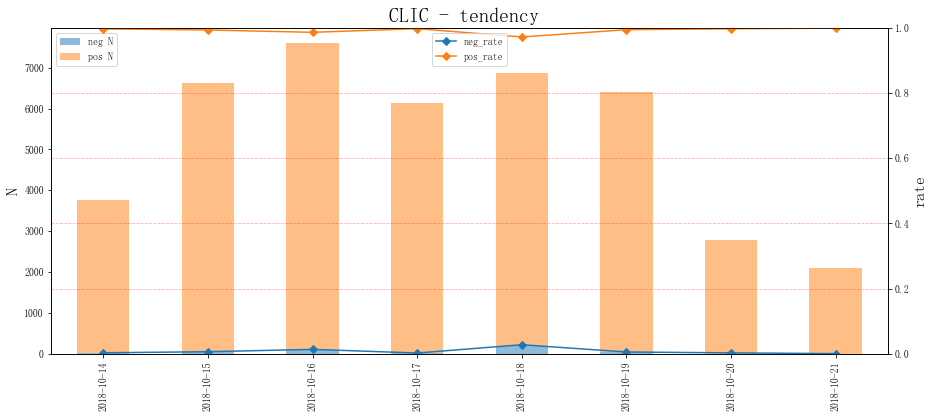

  publishtime  neg   pos   sum  neg_rate  pos_rate
7  2018-10-21    2  2100  2102     0.001     0.999
6  2018-10-20    9  2788  2797     0.003     0.997
5  2018-10-19   38  6363  6401     0.006     0.994
4  2018-10-18  194  6685  6879     0.028     0.972
3  2018-10-17   17  6125  6142     0.003     0.997


In [84]:
plot_tend(tend_count[tend_count['type'] == 3].drop('type', axis = 1), cbirc_day_thing, "CLIC - tendency ")

### 建行北分

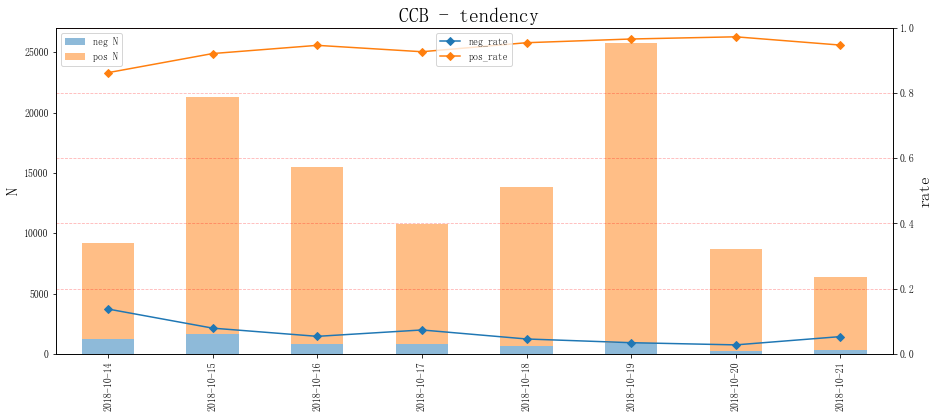

  publishtime  neg    pos    sum  neg_rate  pos_rate
7  2018-10-21  338   6026   6364     0.053     0.947
6  2018-10-20  242   8489   8731     0.028     0.972
5  2018-10-19  887  24862  25749     0.034     0.966
4  2018-10-18  635  13222  13857     0.046     0.954
3  2018-10-17  794  10013  10807     0.073     0.927


In [85]:
plot_tend(tend_count[tend_count['type'] == 4].drop('type', axis = 1), cbirc_day_thing, "CCB - tendency ")

## 补录和预警